In [1]:
import numpy as np

import pandas as pd

from zse.collections import *
from zse.utilities import *

from ase.io import read, write
from matplotlib import cm
from matplotlib import pyplot as plt
from collections import Counter

from sklearn.cluster import KMeans

from collections import defaultdict

from sklearn.metrics import silhouette_samples, silhouette_score, completeness_score, homogeneity_score, mean_squared_error
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn.preprocessing import StandardScaler

import itertools
from itertools import permutations

from sklearn.preprocessing import MinMaxScaler
import sys

from sklearn.neighbors import NearestNeighbors

from kneed import KneeLocator


In [93]:
def get_fw_data(file,code):
    
    # file is the file we want to read from
    # code is the IZA framework code you want data on
    
    file = open(file,'r')
    data = file.readlines()
    file.close()
    
    for i,line in enumerate(data):
        fields = line.split()
        if fields[0] == code:
            start = i
            break
    
    # go through fw chunk and get data
    
    t_sites = {}
    o_sites = {}
    for i,line in enumerate(data[start+1:]):
        line = line.rstrip(' \n')

        # get the t site rings
        
        if 'T' in line and ':' in line:
            fields = line.split(':')
            t_sites[fields[0]]=fields[1]                
        
        # get the o site rings
        
        if 'O' in line and ':' in line:
            fields = line.split(':')
            o_sites[fields[0]]=fields[1]        
        
        fields = line.split()
        if fields[0] == 'Framework':
            end = i+start-1
            break

    return(t_sites,o_sites)    

def numofrings(file,code):
    #might already be a function called counter so come up with very unique names otherwsie function overrides it -- isseue with kernel resets
    '''takes in the file and code name and returns how many of each ring type is present
    arguments: file: dataset
                code: which zeolite is being observed
    returns: number of each rings inside'''
    
    #call function to get data
    tsites, osites = get_fw_data(file,code)
    
    for t in tsites:
        #print('check 1')
        #resets dictionary each tsite
        tsite_dict = {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0}
        #ways to make dictionary without knowing what it is 
        
        #make into vector not dictionary 
        
        #restarts j to 1 to check for ring size
        j = 1
        #go through all of the one tsite
        for i in range(0,len(tsites[t])-2,2):
            #print('check 2')
            #set yes to true
            print('i is',i)
            yes = True
            while yes:
                #print('check 3')
                #print(tsites[t][i])
                #print(int(tsites[t][i]) == j)
                #print(tsite_dict[j])
                #number of rings matches dictionary component
                if int(tsites[t][i]) == j:
                    print('check 4')
                    tsite_dict[j] = tsite_dict[j] + 1
                    #end while loop 
                    yes = False
                #increase j 
                else:
                    
                    j = j + 1
                    print('j is',j)
        print(t,tsite_dict)
        

def nringsvector(code,file):
    '''takes in the file and code name and returns how many of each ring type is present
    arguments: file: dataset
                code: which zeolite is being observed
    returns: vector of number of rings for each tsite'''
    
    #get site data
    tsites, osites = get_fw_data(file,code)
    
    #create empty vector
    A = np.zeros([len(tsites),21])
    
    #coutner for which row of the matrix you are in
    k=0 
    
    #go through each tsite
    for t in tsites:
        #initialize accumulator 
        j=1
        
        #make list of number of rings
        tsites_list = tsites[t].split('_')
        #go through the string for each t list
        for i in range(0,len(tsites_list)):
            #make the while loop true each for loop
            yes = True
            while yes:
                if int(tsites_list[i]) == j:
                    A[k][j] = A[k][j] + 1
                    #end while loop 
                    yes = False
                #increase j 
                else:
                    j = j + 1
        #increase row
        k = k +1 
    return A

def assemblematrix(file):
    fws = get_all_fws()
    fws = fws[1:]
    B = nringsvector('ABW',file)
    for code in fws:
        C = nringsvector(code,file)
        B = np.append(B, C, axis=0)
    return B

def kmeans_percent(file,ncluster):
    A = assemblematrix(file)
    clustering = KMeans(n_clusters = ncluster).fit(A)
    cluster = clustering.labels_

    sorted_clusters = defaultdict(list) #inside parentheses put the type of value ie list int

    fws = get_all_fws()
    #testing to see if Tsite make it a similar cluster
    dict_fws = {}
    count = 0
    for code in fws:
        dict_fws[code] = []
        tsites, osites = get_fw_data(file,code)
        for t in tsites:
            dict_fws[code].append(cluster[count])
            count = count + 1
    allsame = 0
    no1 = 0
    for k in dict_fws:
        if len(dict_fws[k]) > 1:
            no1 = no1 + 1
            avg = sum(dict_fws[k])/len(dict_fws[k])
            if avg == dict_fws[k][0]:
                if dict_fws[k][0] == dict_fws[k][len(dict_fws[k])-1]:
                    allsame = allsame + 1
    per = allsame/no1
    return per, dict_fws 

def weight_avg(file):
    '''Takes in a files frameworks and makes a wieghted average for each framewokr
        Arguments: file - whichever defintion of ring used
        returns: an array of the values'''
    fws = get_all_fws()
    fws_weights = np.zeros([len(fws),21])
    count = 0
    for code in fws:
        #get tsite sata
        tsites, osites = get_fw_data(file,code)
        ts, tm, ti = get_tsites(code)
        #number of tsites
        n = len(tsites)
        #get the matrix of the tsite vectors
        rings = nringsvector(code,file)
        temp = np.zeros(len(rings[0]))
        #to move through the rings matrix
        ring_count = 0
        #calculate weights and add them rows of tsite values together
        for s,m,i in zip(ts,tm,ti):
            #calculate weight
            w = m/sum(tm)
            #make weighted framework
            temp = w*rings[ring_count] + temp
            ring_count = ring_count + 1
        fws_weights[count] = temp
        #increase row number
        count = count + 1
    return fws_weights

def compare4(A,B,nclusters,rand_state,vbool=False):
    #get data 
    Azlist, Aist = Kmeansresults(A,nclusters,rand_state,False)
    Bzlist, Bist = Kmeansresults(B,nclusters,rand_state,False)

    #print(Aist)
    #print(Bist)
    #make default dictionaries to reorganzie the zlist
    Alist = defaultdict(list)
    Blist = defaultdict(list)
    
    #sort the dictionaries numerically
    m = 0
    for k in (sorted(Azlist, key=lambda k: len(Azlist[k]), reverse=True)):
        Alist[m] = Azlist[k]
        m = m + 1
    m = 0
    for k in sorted(Bzlist, key=lambda k: len(Bzlist[k]), reverse=True):
        Blist[m] = Bzlist[k]
        m = m + 1   
    # combinations
    unique_combinations = []
 
    # Getting all permutations of list_1
    # with length of list_2
    permut = itertools.permutations(Alist, len(Blist))
    # zip() is called to pair each permutation
    # and shorter list element into combination
    for comb in permut:
        zipped = zip(comb, Blist)
        unique_combinations.append(list(zipped))
       
    
    #create an array to store values
    array_values = np.zeros([nclusters,nclusters])
    #print('')
    #loop over unique combinations 
    for n in range(nclusters):
        for i in range(nclusters):
            #index into the first part of the ordered pair
            a = unique_combinations[n][i][0]
            #index into the second part of the ordered pair
            b = unique_combinations[n][i][1]
            #find what is in common with the two lists 
            c = list(set(Alist[a]).intersection(Blist[b]))
            #add the value to the array
            array_values[n,i] = len(c)
    #print(array_values)
    #print('')
    
    #store results 
    temp = []
    #print results 
    for t in range(nclusters):
        #print(sum(array_values[t])/253)
        temp.append(sum(array_values[t])/253)
        
    return temp

def isNaN(num):
    return num!= num

def properties(A,values,nclusters,vbool=False):
    '''Arguments:
    
        A: the assembled matrix
        nclusters: number of clusters
        values: data framework to be texted'''
    #get all the frameworks
    fws = get_all_fws()
    #get the clusters
    Azlist, Aist = Kmeansresults(A,nclusters,vbool)
    print(Aist)
    #create a values dictionary to store the frameworks IZa values
    value_dict = defaultdict(list)
    #go through all the clusters
    for k in Azlist:
        #go through all the frameworks in each cluster
        for i in range(len(Azlist[k])):
            #find the index for the framework
            idx = fws.index(Azlist[k][i])
            if isNaN(values[idx]) != True:
                #add the framework's values to the dictionary
                value_dict[k].append(int(values[idx]))
    
    
    #list of the averages
    avg = []
    #list of the standard deviations
    stdev = []
    for k in value_dict:
        x = sum(value_dict[k])/len(value_dict[k])
        avg.append(x)
        y = np.std(value_dict[k])
        stdev.append(y)
                   
    return avg, stdev

def Kmeansresults(A,n,rand_stat,minusBSV = False):
    
    fws = get_all_fws()
    if minusBSV == True:
        fws = np.concatenate((fws[0:39],fws[40:]))
    clustering = KMeans(n,random_state=rand_stat).fit(A)
    cluster = clustering.labels_

    zlist = defaultdict(list)
    for i in range(len(cluster)):
        zlist[cluster[i]].append(fws[i])
    llist = []
    for i in range(n):
        llist.append(len(zlist[i]))
    #llist.sort()
    
    return zlist, llist


In [3]:
A = weight_avg('../Data/vertex_rings.txt')
B = weight_avg('../Data/sastre_rings.txt')
C = weight_avg('../Data/crum_rings.txt')
D = weight_avg('../Data/goetzke_rings.txt')


scaler = MinMaxScaler()
# transform data
scaledA = scaler.fit_transform(A)
scaledB = scaler.fit_transform(B)
scaledC = scaler.fit_transform(C)
scaledD = scaler.fit_transform(D)

In [4]:
iza_values =pd.read_csv('../data/iza_data.csv')
fws = iza_values['Framework'].values
density = iza_values['Density (T sites/ 1000 Å^3)'].values
volume = iza_values['Volume (Å^3)'].values


[63, 100, 57, 17, 16]
[33, 38, 54, 15, 26, 42, 25, 11, 5, 4]
[7, 4, 22, 43, 5, 50, 2, 24, 4, 29, 4, 36, 10, 3, 10]
[19, 13, 5, 11, 31, 3, 9, 20, 27, 5, 50, 1, 2, 3, 7, 1, 3, 10, 2, 31]
[33, 11, 26, 19, 10, 8, 30, 5, 3, 29, 1, 8, 3, 2, 3, 5, 1, 2, 2, 1, 14, 1, 10, 22, 4]
[5, 18, 8, 18, 25, 5, 3, 1, 23, 1, 7, 2, 11, 2, 2, 25, 9, 17, 1, 5, 12, 3, 1, 1, 9, 1, 1, 19, 4, 14]
[4, 3, 29, 23, 14, 9, 8, 3, 18, 1, 2, 12, 21, 1, 1, 24, 1, 6, 1, 12, 4, 1, 1, 1, 2, 6, 3, 4, 4, 3, 9, 16, 3, 2, 1]
[4, 14, 14, 1, 4, 3, 2, 15, 8, 2, 8, 1, 4, 3, 21, 2, 1, 3, 3, 1, 8, 10, 7, 2, 20, 16, 2, 1, 2, 1, 22, 8, 3, 1, 1, 3, 12, 1, 18, 1]
[19, 22, 13, 8, 3, 9, 9, 1, 1, 15, 1, 2, 5, 3, 1, 7, 3, 1, 15, 1, 10, 2, 4, 4, 1, 15, 1, 4, 1, 2, 2, 1, 1, 6, 8, 18, 4, 2, 8, 1, 3, 12, 1, 2, 1]
[25, 11, 4, 7, 7, 1, 1, 12, 17, 3, 4, 2, 5, 3, 1, 16, 1, 3, 1, 14, 8, 1, 1, 1, 10, 1, 5, 2, 2, 1, 2, 1, 2, 3, 3, 19, 1, 3, 3, 9, 1, 1, 1, 16, 3, 1, 1, 2, 10, 1]
[16, 15, 9, 1, 5, 4, 4, 2, 1, 8, 3, 12, 2, 26, 1, 4, 10, 1, 1, 1, 3, 1, 1, 4

<Figure size 360x360 with 0 Axes>

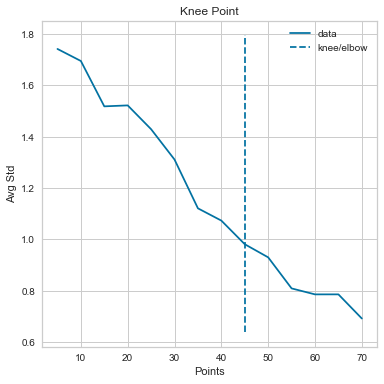

In [6]:
std_list = []
x = np.linspace(5,70,14)
for i in range(5,71,5):
    avg, std = properties(scaledD,density,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
#plt.plot(x,std_list)

knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Avg Std")

plt.savefig('ex_elbow.png',dpi=300)

In [6]:
y = np.zeros([58,25])
d= 0 
for n in range(1,500,20):
    for i in range(2,60):
        clustering = KMeans(i,random_state =i ).fit(scaledA)
        cluster = clustering.labels_
        y[i-2,d] = silhouette_score(scaledA,cluster)
    d = d + 1

In [17]:
g = []
for n in range(1,500,20):
    g.append(n)
d_sil = pd.DataFrame(y,columns = g)
print(d_sil)

         1         21        41        61        81        101       121  \
0   0.350818  0.350818  0.350818  0.350818  0.350818  0.350818  0.350818   
1   0.375373  0.375373  0.375373  0.375373  0.375373  0.375373  0.375373   
2   0.403370  0.403370  0.403370  0.403370  0.403370  0.403370  0.403370   
3   0.346925  0.346925  0.346925  0.346925  0.346925  0.346925  0.346925   
4   0.316099  0.316099  0.316099  0.316099  0.316099  0.316099  0.316099   
5   0.298954  0.298954  0.298954  0.298954  0.298954  0.298954  0.298954   
6   0.313502  0.313502  0.313502  0.313502  0.313502  0.313502  0.313502   
7   0.319535  0.319535  0.319535  0.319535  0.319535  0.319535  0.319535   
8   0.303927  0.303927  0.303927  0.303927  0.303927  0.303927  0.303927   
9   0.329968  0.329968  0.329968  0.329968  0.329968  0.329968  0.329968   
10  0.312870  0.312870  0.312870  0.312870  0.312870  0.312870  0.312870   
11  0.284220  0.284220  0.284220  0.284220  0.284220  0.284220  0.284220   
12  0.307518

In [24]:
y = np.zeros([58,25])
d= 0 
for n in range(1,500,20):
    for i in range(2,60):
        clustering = KMeans(i,random_state =n ).fit(scaledB)
        cluster = clustering.labels_
        y[i-2,d] = silhouette_score(scaledB,cluster)
    d = d + 1
g = []
for n in range(1,500,20):
    g.append(n)
d_sil = pd.DataFrame(y,columns = g)
print(d_sil)

         1         21        41        61        81        101       121  \
0   0.343798  0.343749  0.343798  0.343749  0.343749  0.343749  0.343749   
1   0.355224  0.355224  0.355224  0.355224  0.355224  0.355224  0.355224   
2   0.383266  0.383266  0.383266  0.383266  0.383266  0.382352  0.318520   
3   0.325402  0.325252  0.303707  0.326716  0.341108  0.325402  0.325402   
4   0.323836  0.326748  0.327083  0.323836  0.323836  0.323836  0.326748   
5   0.337889  0.335941  0.334297  0.339689  0.336478  0.337661  0.287421   
6   0.345266  0.347856  0.342633  0.345686  0.345682  0.298364  0.303636   
7   0.312047  0.353198  0.313234  0.343298  0.353466  0.360511  0.355105   
8   0.319199  0.318784  0.318545  0.320454  0.318304  0.317866  0.317077   
9   0.309151  0.333504  0.326749  0.327740  0.332835  0.330597  0.332330   
10  0.320749  0.337861  0.322288  0.334620  0.335188  0.340786  0.344796   
11  0.336806  0.345938  0.320634  0.342661  0.307569  0.349863  0.317562   
12  0.321385

In [27]:
y = np.zeros([58,25])
d= 0 
for n in range(1,500,20):
    for i in range(2,60):
        clustering = KMeans(i,random_state =n ).fit(scaledC)
        cluster = clustering.labels_
        y[i-2,d] = silhouette_score(scaledC,cluster)
    d = d + 1
g = []
for n in range(1,500,20):
    g.append(n)
d_sil = pd.DataFrame(y,columns = g)
print(d_sil)

KeyboardInterrupt: 

In [26]:
y = np.zeros([58,25])
d= 0 
for n in range(1,500,20):
    for i in range(2,60):
        clustering = KMeans(i,random_state =n ).fit(scaledD)
        cluster = clustering.labels_
        y[i-2,d] = silhouette_score(scaledD,cluster)
    d = d + 1
g = []
for n in range(1,500,20):
    g.append(n)
d_sil = pd.DataFrame(y,columns = g)
print(d_sil)

         1         21        41        61        81        101       121  \
0   0.299561  0.299972  0.299837  0.300532  0.299972  0.300151  0.301040   
1   0.249811  0.250833  0.316489  0.250833  0.268676  0.249811  0.249811   
2   0.335159  0.333802  0.334429  0.280020  0.333802  0.281178  0.333802   
3   0.260902  0.263786  0.263851  0.247468  0.251772  0.257919  0.260210   
4   0.251411  0.256817  0.251411  0.249698  0.252514  0.251411  0.251411   
5   0.263862  0.264896  0.257279  0.245230  0.264097  0.259060  0.257961   
6   0.272330  0.255700  0.261601  0.254723  0.272203  0.257303  0.256013   
7   0.285284  0.257692  0.266238  0.257926  0.238814  0.281784  0.284843   
8   0.251668  0.279341  0.247470  0.242396  0.237872  0.271067  0.265589   
9   0.262446  0.250949  0.245215  0.267105  0.230083  0.264453  0.285039   
10  0.233825  0.273862  0.264264  0.249666  0.272250  0.253838  0.274901   
11  0.245386  0.299225  0.263690  0.267710  0.287216  0.259986  0.228980   
12  0.251298

In [31]:
x = defaultdict(list)
for i in range(1,500):
    for t in range(2,50):
        clustering = KMeans(t,random_state =n ).fit(scaledA)
        cluster = clustering.labels_
        x[t].append(silhouette_score(scaledA,cluster))
print(x)

defaultdict(<class 'list'>, {2: [0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0.35081814727796784, 0

In [ ]:
x = np.zeros([499,48])
for i in range(1,500):
    for t in range(2,50):
        clustering = KMeans(t,random_state =n ).fit(scaledB)
        cluster = clustering.labels_
        x[i-1,t-2] = silhouette_score(scaledB,cluster)
print(x)

In [ ]:
x = np.zeros([499,48])
for i in range(1,500):
    for t in range(2,50):
        clustering = KMeans(t,random_state =n ).fit(scaledC)
        cluster = clustering.labels_
        x[i-1,t-2] = silhouette_score(scaledC,cluster)
print(x)

In [ ]:
x = np.zeros([499,48])
for i in range(1,500):
    for t in range(2,50):
        clustering = KMeans(t,random_state =n ).fit(scaledD)
        cluster = clustering.labels_
        x[i-1,t-2] = silhouette_score(scaledD,cluster)
print(x)

In [10]:
list1 = [1,2,3]
list2 = [1,2,3]
unique_combinations = []
# with length of list_2
permut = itertools.permutations(list1, len(list2))
# zip() is called to pair each permutation
# and shorter list element into combination
for comb in permut:
    zipped = zip(comb, list2)
    unique_combinations.append(list(zipped))
print(unique_combinations)

[[(1, 1), (2, 2), (3, 3)], [(1, 1), (3, 2), (2, 3)], [(2, 1), (1, 2), (3, 3)], [(2, 1), (3, 2), (1, 3)], [(3, 1), (1, 2), (2, 3)], [(3, 1), (2, 2), (1, 3)]]


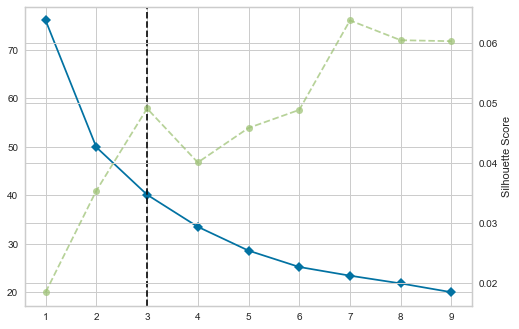

In [45]:
scaler = MinMaxScaler()
AminusBSV = np.concatenate((scaledA[0:39],scaledA[40:]))
# transform data



model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(AminusBSV)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

'''knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Number of Clusters")
plt.ylabel("")'''

plt.savefig('ex_BSVwoElbow.png',dpi=300)

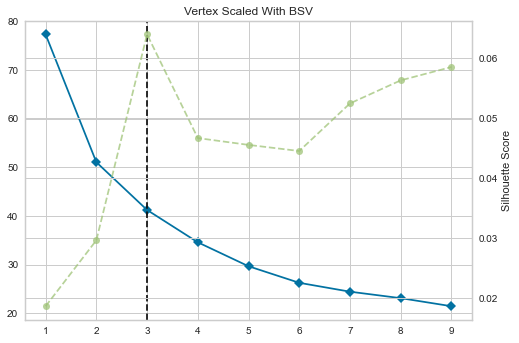

In [47]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(scaledA)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Vertex Scaled With BSV')
'''knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Number of Clusters")
plt.ylabel("")'''

plt.savefig('ex_BSVwoElbow.png',dpi=300)

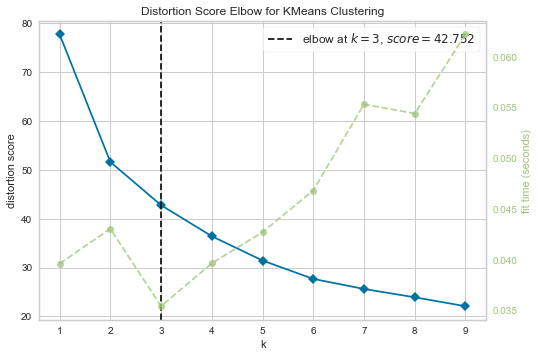

<Figure size 576x396 with 0 Axes>

In [53]:
scaler = MinMaxScaler()
BminusBSV = np.concatenate((scaledB[0:39],scaledB[40:]))
# transform data



model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(BminusBSV)
visualizer.show()
'''ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Distortion Score', color='b')
ax2.set_ylabel('Fit Time (seconds)', color='g')
plt.title('Sastre Scaled Without BSV')

knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Number of Clusters")
plt.ylabel("")'''

plt.savefig('WithoutBSV.png',dpi=300)

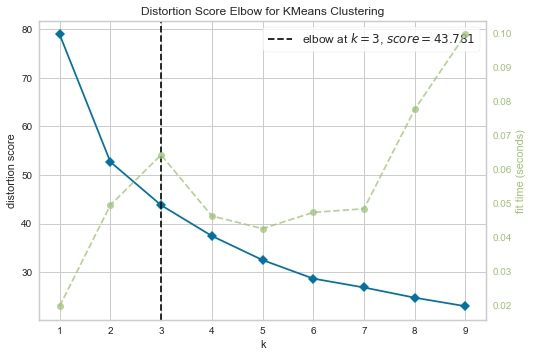

<Figure size 576x396 with 0 Axes>

In [54]:

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(scaledB)
visualizer.show()
'''plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Sastre Scaled With BSV')
knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Number of Clusters")
plt.ylabel("")'''

plt.savefig('WithBSV.png',dpi=300)

'knee = KneeLocator(x, std_list, S=1, curve=\'convex\', direction=\'decreasing\', interp_method=\'polynomial\')\nfig = plt.figure(figsize=(5, 5))\nknee.plot_knee()\nplt.xlabel("Number of Clusters")\nplt.ylabel("")'

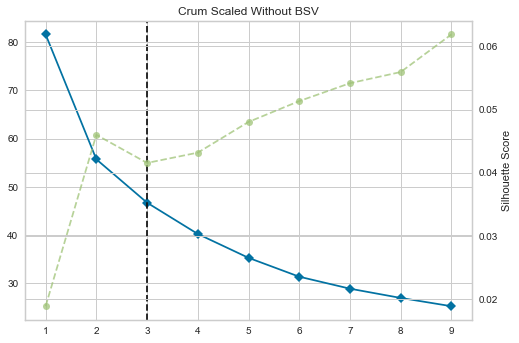

In [34]:
scaler = MinMaxScaler()
CminusBSV = np.concatenate((scaledC[0:39],scaledC[40:]))
# transform data



model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(CminusBSV)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Crum Scaled Without BSV')

'''knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Number of Clusters")
plt.ylabel("")'''

#plt.savefig('ex_BSVwoElbow.png',dpi=300)

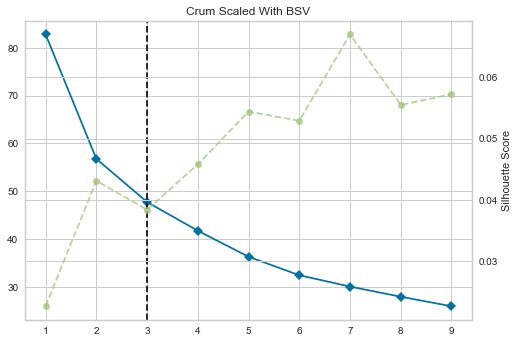

In [32]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(scaledC)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Crum Scaled With BSV')
'''knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Number of Clusters")
plt.ylabel("")'''

plt.savefig('ex_BSVwoElbow.png',dpi=300)

'knee = KneeLocator(x, std_list, S=1, curve=\'convex\', direction=\'decreasing\', interp_method=\'polynomial\')\nfig = plt.figure(figsize=(5, 5))\nknee.plot_knee()\nplt.xlabel("Number of Clusters")\nplt.ylabel("")'

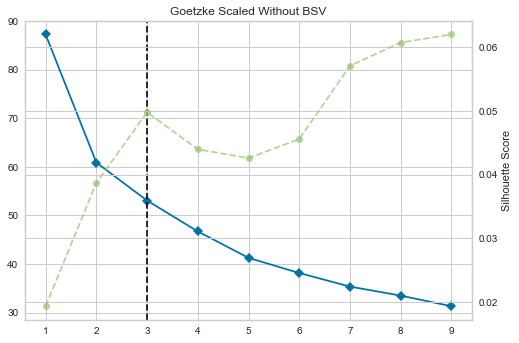

In [35]:
scaler = MinMaxScaler()
CminusBSV = np.concatenate((scaledD[0:39],scaledD[40:]))
# transform data



model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(CminusBSV)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Goetzke Scaled Without BSV')

'''knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Number of Clusters")
plt.ylabel("")'''

#plt.savefig('ex_BSVwoElbow.png',dpi=300)

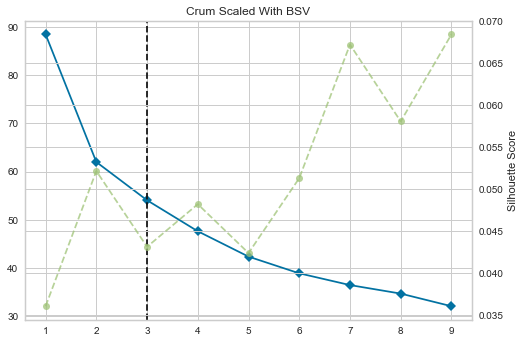

In [41]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(scaledD)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Crum Scaled With BSV')
'''knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Number of Clusters")
plt.ylabel("")'''

plt.savefig('ex_BSVwoElbow.png',dpi=300)

In [86]:
A = np.zeros([8,4])
x = np.linspace(2,10,8)
for i in range(2,10):
    avg, std = properties(scaledA,density,i,vbool=False)
    A[i-2,0] = sum(std)/len(std)
    avg, std = properties(scaledB,density,i,vbool=False)
    A[i-2,1] = sum(std)/len(std)
    avg, std = properties(scaledC,density,i,vbool=False)
    A[i-2,2] = sum(std)/len(std)
    avg, std = properties(scaledC,density,i,vbool=False)
    A[i-2,3] = sum(std)/len(std)

[159, 94]
[94, 159]
[95, 158]
[95, 158]
[97, 130, 26]
[114, 89, 50]
[25, 132, 96]
[25, 132, 96]
[97, 88, 54, 14]
[95, 116, 27, 15]
[95, 117, 26, 15]
[95, 117, 26, 15]
[56, 97, 58, 16, 26]
[54, 99, 61, 15, 24]
[64, 23, 99, 16, 51]
[64, 23, 99, 16, 51]
[73, 54, 24, 29, 15, 58]
[61, 21, 82, 52, 23, 14]
[58, 59, 85, 24, 17, 10]
[58, 59, 85, 24, 17, 10]
[57, 3, 54, 48, 55, 23, 13]
[59, 21, 21, 4, 10, 80, 58]
[24, 5, 9, 51, 15, 87, 62]
[24, 5, 9, 51, 15, 87, 62]
[30, 54, 26, 59, 4, 3, 69, 8]
[4, 56, 42, 18, 55, 10, 50, 18]
[15, 58, 24, 86, 55, 2, 5, 8]
[15, 58, 24, 86, 55, 2, 5, 8]
[6, 49, 52, 9, 59, 11, 42, 21, 4]
[3, 45, 50, 13, 58, 46, 18, 4, 16]
[3, 86, 59, 56, 8, 15, 5, 20, 1]
[3, 86, 59, 56, 8, 15, 5, 20, 1]


In [87]:
df = pd.DataFrame (A, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = range(2,10)
print(df)

     Vertex    Sastre      Crum   Goetzke
2  1.913411  1.913411  1.922338  1.922338
3  1.826173  1.902392  1.832684  1.832684
4  1.822983  1.785212  1.774908  1.774908
5  1.817821  1.812085  1.810838  1.810838
6  1.822471  1.849945  1.876983  1.876983
7  1.729896  1.786095  1.814790  1.814790
8  1.712586  1.752969  1.710338  1.710338
9  1.788240  1.728781  1.593984  1.593984


In [63]:
Aa = assemblematrix('../Data/vertex_rings.txt')
Bb = assemblematrix('../Data/sastre_rings.txt')
Cc = assemblematrix('../Data/crum_rings.txt')
Dd = assemblematrix('../Data/goetzke_rings.txt')

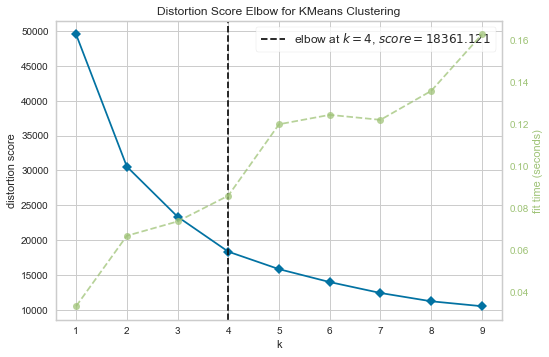

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [65]:

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(Aa)
visualizer.show()



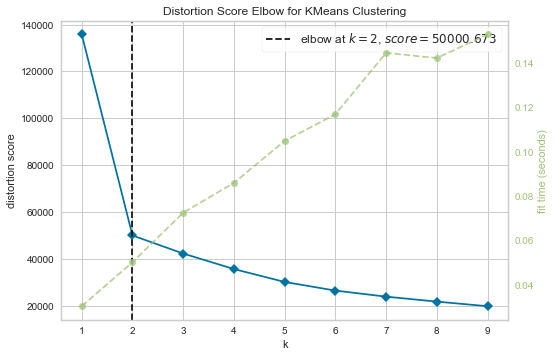

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [66]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(Bb)
visualizer.show()

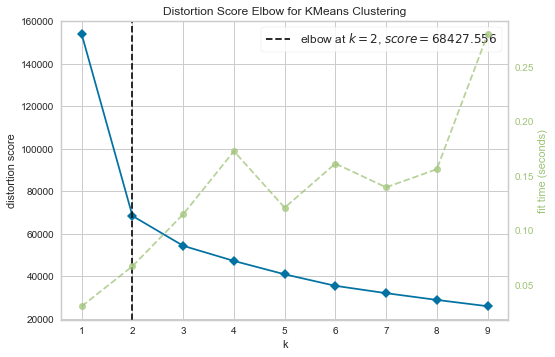

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [67]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(Cc)
visualizer.show()

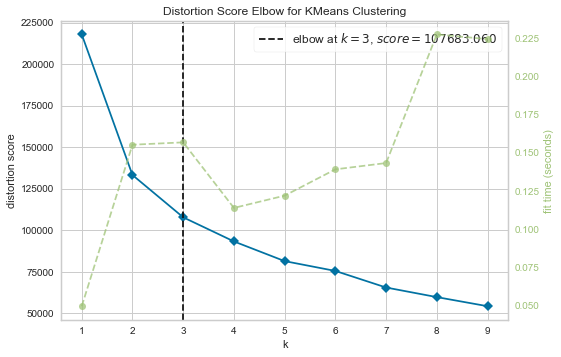

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [68]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(Dd)
visualizer.show()

In [73]:
tsites, osites = get_fw_data('../Data/crum_rings.txt','BSV')

In [76]:
print(tsites['T1'])

4_4_4_6_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12


In [77]:
print(len(tsites['T1']))

889


In [78]:
889-8

881

In [79]:
882/3

294.0

In [85]:
compare4(scaledC,scaledB,3,rand_state=1,vbool=False)

[131, 96, 26]
[114, 89, 50]
[[114.  89.  26.]
 [114.   0.   7.]
 [  0.   0.  26.]]
0.9051383399209486
0.4782608695652174
0.10276679841897234


[0.9051383399209486, 0.4782608695652174, 0.10276679841897234]

In [88]:
x = '_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12'

In [89]:
print(len(x))

882


In [90]:
x = np.linspace(1,500,20)
print(x)

[  1.          27.26315789  53.52631579  79.78947368 106.05263158
 132.31578947 158.57894737 184.84210526 211.10526316 237.36842105
 263.63157895 289.89473684 316.15789474 342.42105263 368.68421053
 394.94736842 421.21052632 447.47368421 473.73684211 500.        ]


In [94]:
def Kmeansresults(A,n,rand_state,minusBSV = False):
    
    fws = get_all_fws()
    if minusBSV == True:
        fws = np.concatenate((fws[0:39],fws[40:]))
    clustering = KMeans(n,random_state=rand_state).fit(A)
    cluster = clustering.labels_

    zlist = defaultdict(list)
    for i in range(len(cluster)):
        zlist[cluster[i]].append(fws[i])
    llist = []
    for i in range(n):
        llist.append(len(zlist[i]))
    #llist.sort()
    
    return zlist, llist

keys = [scaledA,scaledB,scaledC,scaledD]
x = np.linspace(1,500,20)
for t in x:
    compare_array = np.zeros([4,4])

    c = 0
    d = 0
    for i in keys:
        for n in range(d,4):
            compare_array[c,n] = max(compare4(i,keys[n],3,int(t),False))
            compare_array[n,c] = max(compare4(i,keys[n],3,int(t),False))
        c = c + 1
        d = d + 1
    #print(compare_array) 

    df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
    df.index = ['Vertex','Sastre','Crum','Goetzke']
    print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.905138  0.988142  0.525692
Sastre   0.905138  1.000000  0.905138  0.462451
Crum     0.988142  0.905138  1.000000  0.521739
Goetzke  0.525692  0.462451  0.521739  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.905138  0.988142  0.869565
Sastre   0.905138  1.000000  0.905138  0.948617
Crum     0.988142  0.905138  1.000000  0.869565
Goetzke  0.869565  0.948617  0.869565  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.905138  0.976285  0.778656
Sastre   0.905138  1.000000  0.901186  0.873518
Crum     0.976285  0.901186  1.000000  0.774704
Goetzke  0.778656  0.873518  0.774704  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.988142  0.988142  0.758893
Sastre   0.988142  1.000000  0.992095  0.766798
Crum     0.988142  0.992095  1.000000  0.766798
Goetzke  0.758893  0.766798  0.766798  1.000000
           Vertex    Sastre      Crum   

In [95]:
def Kmeansresults(A,n,rand_state,minusBSV = False):
    
    fws = get_all_fws()
    if minusBSV == True:
        fws = np.concatenate((fws[0:39],fws[40:]))
    clustering = KMeans(n,random_state=rand_state).fit(A)
    cluster = clustering.labels_

    zlist = defaultdict(list)
    for i in range(len(cluster)):
        zlist[cluster[i]].append(fws[i])
    llist = []
    for i in range(n):
        llist.append(len(zlist[i]))
    #llist.sort()
    
    return zlist, llist

keys = [scaledA,scaledB,scaledC,scaledD]
x = np.linspace(1,500,20)
for t in x:
    compare_array = np.zeros([4,4])

    c = 0
    d = 0
    for i in keys:
        for n in range(d,4):
            compare_array[c,n] = max(compare4(i,keys[n],4,int(t),False))
            compare_array[n,c] = max(compare4(i,keys[n],4,int(t),False))
        c = c + 1
        d = d + 1
    #print(compare_array) 

    df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
    df.index = ['Vertex','Sastre','Crum','Goetzke']
    print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.988142  0.988142  0.956522
Sastre   0.988142  1.000000  0.992095  0.960474
Crum     0.988142  0.992095  1.000000  0.968379
Goetzke  0.956522  0.960474  0.968379  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.988142  0.988142  0.952569
Sastre   0.988142  1.000000  0.984190  0.956522
Crum     0.988142  0.984190  1.000000  0.964427
Goetzke  0.952569  0.956522  0.964427  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.992095  0.988142  0.956522
Sastre   0.992095  1.000000  0.988142  0.956522
Crum     0.988142  0.988142  1.000000  0.968379
Goetzke  0.956522  0.956522  0.968379  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.909091  0.897233  0.869565
Sastre   0.909091  1.000000  0.988142  0.952569
Crum     0.897233  0.988142  1.000000  0.964427
Goetzke  0.869565  0.952569  0.964427  1.000000
           Vertex    Sastre      Crum   

In [96]:
def Kmeansresults(A,n,rand_state,minusBSV = False):
    
    fws = get_all_fws()
    if minusBSV == True:
        fws = np.concatenate((fws[0:39],fws[40:]))
    clustering = KMeans(n,random_state=rand_state).fit(A)
    cluster = clustering.labels_

    zlist = defaultdict(list)
    for i in range(len(cluster)):
        zlist[cluster[i]].append(fws[i])
    llist = []
    for i in range(n):
        llist.append(len(zlist[i]))
    #llist.sort()
    
    return zlist, llist

keys = [scaledA,scaledB,scaledC,scaledD]
x = np.linspace(1,500,20)
for t in x:
    compare_array = np.zeros([4,4])

    c = 0
    d = 0
    for i in keys:
        for n in range(d,4):
            compare_array[c,n] = max(compare4(i,keys[n],9,int(t),False))
            compare_array[n,c] = max(compare4(i,keys[n],9,int(t),False))
        c = c + 1
        d = d + 1
    #print(compare_array) 

    df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
    df.index = ['Vertex','Sastre','Crum','Goetzke']
    print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.458498  0.434783  0.189723
Sastre   0.458498  1.000000  0.324111  0.118577
Crum     0.434783  0.324111  1.000000  0.304348
Goetzke  0.189723  0.118577  0.304348  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.252964  0.478261  0.367589
Sastre   0.252964  1.000000  0.671937  0.067194
Crum     0.478261  0.671937  1.000000  0.134387
Goetzke  0.367589  0.067194  0.134387  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.312253  0.221344  0.177866
Sastre   0.312253  1.000000  0.122530  0.098814
Crum     0.221344  0.122530  1.000000  0.707510
Goetzke  0.177866  0.098814  0.707510  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.324111  0.138340  0.071146
Sastre   0.324111  1.000000  0.474308  0.359684
Crum     0.138340  0.474308  1.000000  0.169960
Goetzke  0.071146  0.359684  0.169960  1.000000
           Vertex    Sastre      Crum   